In [20]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [21]:
def read_h5_file(output_file):
    simulation_data = {}
    with h5py.File(output_file, 'r') as f:
        # Read global attributes safely
        attributes = {
            "total_chicken_population": f.attrs.get("total_chicken_population", None),
            "duck_symptomatic_probability": f.attrs.get("duck_symptomatic_probability", None),
            "rescale_factor": f.attrs.get("rescale_factor", None)
        }

        # Iterate over simulation groups
        for sim_name in f:
            sim_group = f[sim_name]
            
            if "time" in sim_group and "state" in sim_group:
                t = sim_group["time"][:]
                y = sim_group["state"][:]
                simulation_data[sim_name] = {"time": t, "state": y}
            else:
                print(f"Warning: Missing 'time' or 'state' in {sim_name}")

    return simulation_data, attributes

In [22]:
def plot_mean_and_individual_infected(simulation_data, chicken_level, symprob, xlim=170):
    infected_matrix = []

    for sim_name, data in simulation_data.items():
        t = data["time"]
        y = data["state"]
        infected = np.sum(y[:, :, :, 3:5], axis=(1, 2, 3))  # Sum symptomatic + asymptomatic

        # Build time series on integer grid from 0 to xlim
        int_infected = []
        last_value = 0.0
        for ti in range(xlim + 1):
            mask = t <= ti
            if np.any(mask):
                last_value = infected[mask][-1]
            int_infected.append(last_value)

        infected_matrix.append(int_infected)
        plt.plot(range(xlim + 1), int_infected, color='red', alpha=0.05)  # Individual curve

    # Compute and plot the mean curve
    infected_array = np.array(infected_matrix)
    mean_infected = np.mean(infected_array, axis=0)
    plt.plot(range(xlim + 1), mean_infected, color='black', label='Mean Infected', linewidth=2)

    plt.xlabel("Time (days)", fontsize=14)
    plt.ylabel("Infectious Population (Symptomatic + Asymptomatic)", fontsize=10)
    plt.title(f"Number of Infectious Birds, Chicken Population {chicken_level}, Duck Symptomatic Probability {symprob}", fontsize=14)
    plt.xlim(0, xlim)
    plt.ylim(0, 40)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

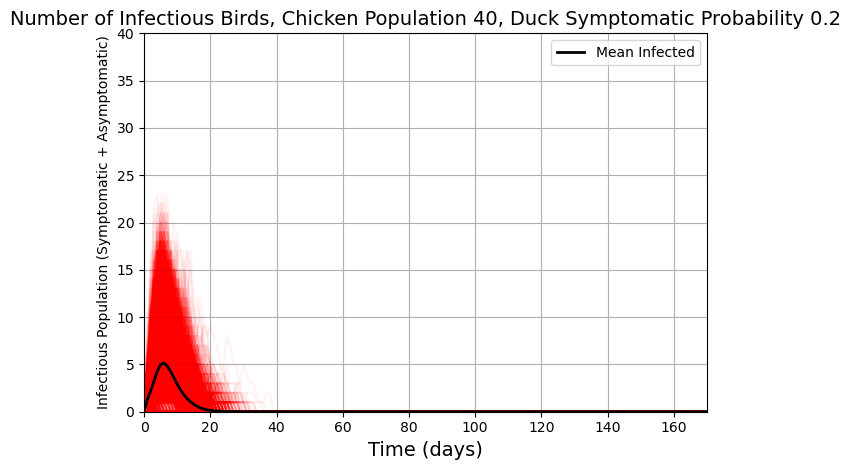

In [23]:
chicken = 40
symprob = 0.2
rescale = 3.0
file_template = "Time_Series/chicken_{}_symprob_{}_rescale_{}.h5"
output_file = file_template.format(chicken, symprob, rescale)

simulation_data, _ = read_h5_file(output_file)
plot_mean_and_individual_infected(simulation_data, chicken_level=chicken, symprob=symprob)


In [24]:

def plot_mean_and_individual_deaths(simulation_data, chicken_level, symprob, xlim=200):
    deaths_matrix = []

    plt.figure(figsize=(10, 6))

    for sim_name, data in simulation_data.items():
        t = data["time"]
        y = data["state"]
        deaths = np.sum(y[:, :, :, 6], axis=(1, 2))  # 6th compartment = deaths

        # Interpolate to integer time steps up to xlim, padding with last value
        int_deaths = []
        last_value = 0.0
        for ti in range(xlim + 1):
            mask = t <= ti
            if np.any(mask):
                last_value = deaths[mask][-1]
            int_deaths.append(last_value)

        deaths_matrix.append(int_deaths)
        plt.plot(range(xlim + 1), int_deaths, color='blue', alpha=0.05)

    # Mean curve
    deaths_array = np.array(deaths_matrix)
    mean_deaths = np.mean(deaths_array, axis=0)
    plt.plot(range(xlim + 1), mean_deaths, color='black', label='Mean Deaths', linewidth=2)

    plt.xlabel("Time (Days)", fontsize=14)
    plt.ylabel("Dead Population", fontsize=14)
    plt.title(f"Deaths Time Series - Chicken Population {chicken_level}, Duck Symptomatic Probability {symprob}", fontsize=14)
    plt.ylim(0, 40)
    plt.xlim(0, 170)  # Still only display up to 170
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


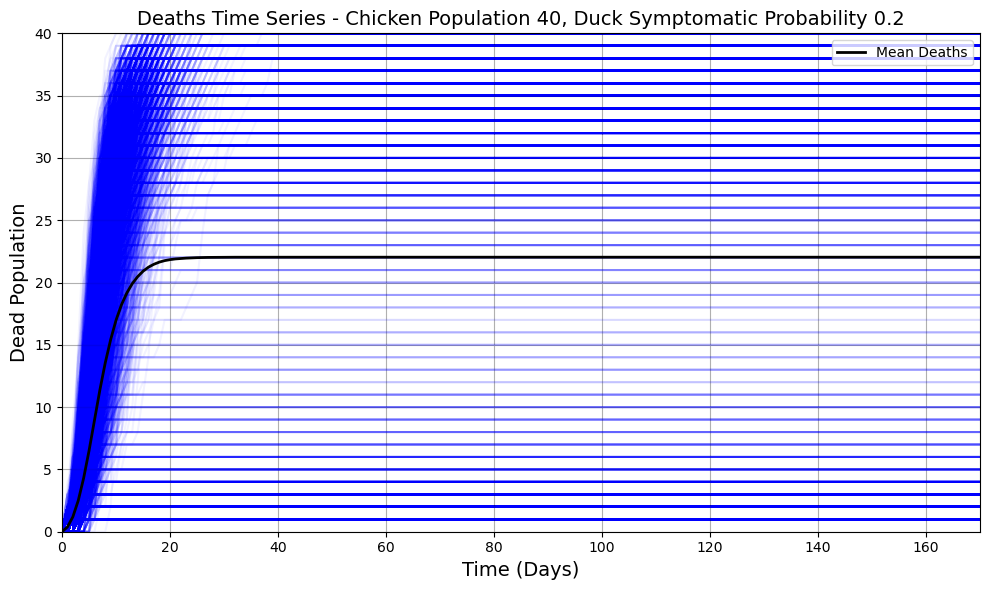

In [25]:
simulation_data, _ = read_h5_file(output_file)
plot_mean_and_individual_deaths(simulation_data, chicken_level=chicken, symprob=symprob)


In [26]:
def plot_mean_and_individual_removed(simulation_data, chicken_level, symprob, xlim=200):
    # Determine max usable time
    max_time = int(min(xlim, max(data["time"][-1] for data in simulation_data.values())))
    removed_matrix = []

    plt.figure(figsize=(10, 6))

    for sim_name, data in simulation_data.items():
        t = data["time"]
        y = data["state"]
        removed = np.sum(y[:, :, :, 5:], axis=(1, 2, 3))  # deaths + recoveries

        # Interpolate to integer time steps using "latest value up to that time"
        int_removed = []
        for ti in range(max_time + 1):
            mask = t <= ti
            if np.any(mask):
                int_removed.append(removed[mask][-1])
            else:
                int_removed.append(0.0)
        removed_matrix.append(int_removed)

        # Plot raw trajectory
        plt.plot(range(max_time + 1), int_removed, color='green', alpha=0.05)

    # Mean curve
    removed_array = np.array(removed_matrix)
    mean_removed = np.mean(removed_array, axis=0)
    plt.plot(range(max_time + 1), mean_removed, color='black', label='Mean Removed', linewidth=2)

    plt.xlabel("Time (Days)",fontsize=14)
    plt.ylabel("Removed Population", fontsize=14)
    plt.title(f"Removed (Deaths and Recoveries) Time Series - Chicken Population {chicken_level}, Duck Symptomatic Probability {symprob}", fontsize=14)
    plt.xlim(0, max_time)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



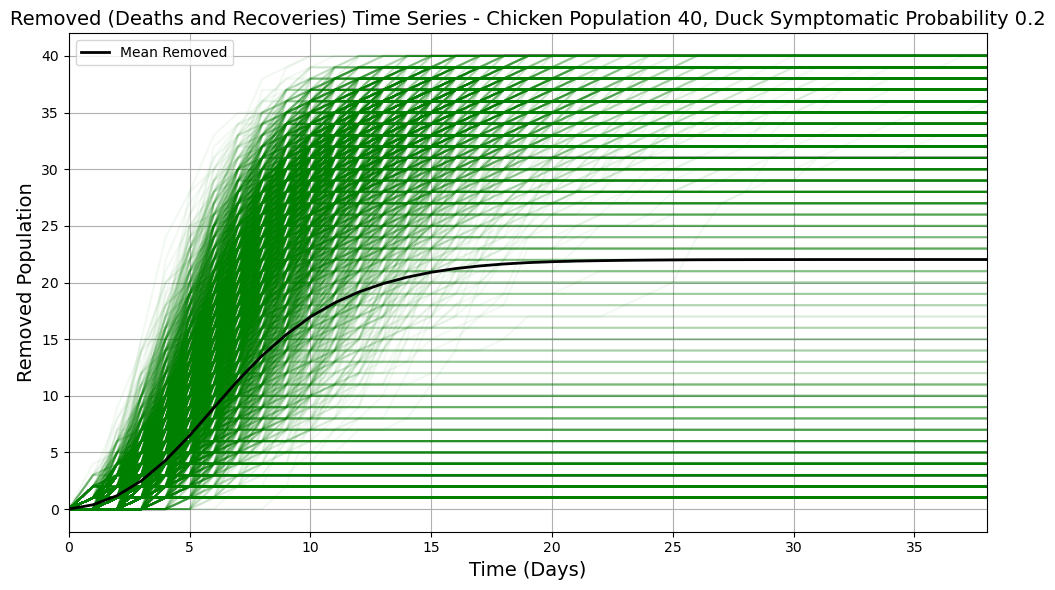

In [27]:
simulation_data, _ = read_h5_file(output_file)
plot_mean_and_individual_removed(simulation_data, chicken_level=chicken, symprob=symprob)
